# Programing exercise 10: Monte Carlo wave function method

Due on Monday, 21.01.2019, 14.15h

__This exercise sheet has been solved by:__ Mathieu Kaltschmidt and Carl von Randow

### Total: 100 points

## The problem

We will again consider the EIT problem from programming exercise 9.

Light propagating through an atomic medium is usually scattered and thus absorbed thorough near-resonant coupling to a transition from the ground ($|g_1\rangle$) to an excited ($|e\rangle$) electronic state. If a second light field ("coupling laser") couples the excited state to a third, long-lived, state ($|g_2\rangle$), the medium can again become transparent for the first light field ("probe laser"). This effect, called electromagnetically induced transparency (EIT) - the above description referring to the lambda confuration for obvious reasons - has led to a plethora of applications, see e.g. Rev. Mod. Phys. 77, 633 (2005) [1]. The dynamics of the atomic populations can be simulated using the Lindbald master equation approach, accounting for the coherent driving laser fields, and incoherent processes such as spontaneous emission and dephasing, e.g. due to finite laser linewidth. The complex refractive index of the atomic medium is given by $n=\sqrt{1+\chi}\approx 1 + (\chi_R + \chi_I)/2$, where the real and imaginary part of complex  susceptibility $\chi$ account for diffraction and absorption of the probe light respectively. $\chi$ depends on the polarizability of the atomic dipoles in the medium and is thus proportional to expectation value of the operator $|g_1\rangle \langle e|$, i.e. $\rm{tr}[|g_1\rangle \langle e| \rho] = \langle e| \rho |g_1 \rangle = \rho_{eg_1}$. This coherence will thus be the main object of interest.

The interaction with the laser fields is described by the Hamiltonian (in rotating wave approximation, in the basis $\{|g_1\rangle,|g_2\rangle,|e\rangle\}$, following the sign convention used in [1])
$$
H=\left[
\begin{array}{ccc}
0 & 0 & -\Omega_p/2 \\
0 & \Delta_p-\Delta_c & -\Omega_c/2 \\
-\Omega_p/2 & -\Omega_c/2 & \Delta_p
\end{array}
\right]
$$
where $\Omega$'s are Rabi-frequencies and $\Delta$'s are the detunings of the lasers from the respective atomic transitions. $\Delta_p-\Delta_c$ is the "two-photon-detuning" sometimes abbreviated as $\delta_2$.

The dissipative processes we want to consider are the spontaneous emission from $e$ to both ground states $g_1$ and $g_2$ and later also the decay from $g_2$ to $g_1$, which breaks the EIT. These are accouted for by the jump operators
$$
\Gamma_{eg_1} = \sqrt{\gamma_p} |g_1\rangle \langle e|, \quad \Gamma_{eg_2} = \sqrt{\gamma_c} |g_2\rangle \langle e|, \quad\Gamma_{g_2g_1} = \sqrt{\gamma_g} |g_1\rangle \langle g_2| .
$$
The resulting master equation reads
$$
\dot\rho = -i[H,\rho] + \mathcal{L}_{\Gamma_{eg_1}} [\rho]+ \mathcal{L}_{\Gamma_{eg_2}} [\rho]+ \mathcal{L}_{\Gamma_{g_2g_1}} [\rho]
$$
with the Lindblad superoperator
$$
\mathcal{L}_{\Gamma_x} [\rho] = \Gamma_x \rho \Gamma_x^\dagger - \frac{1}{2}(\Gamma_x^\dagger\Gamma_x \rho + \rho \Gamma_x^\dagger\Gamma_x)
$$

This time we want to solve the dynamics using the Monte Carlo wave function technique. For such a small system (3-dimensional Hilbert space) the method will not be more efficient than directly integrating the master equation. However, when it comes to many-body spin systems for example, the reduction from a $4^N$ to a $2^N$ dimensional problem at the expense of doing stochastic sampling, can be extremely useful.

In [1]:
# load standard libraries
import numpy as np   
import numpy.linalg as LA
import matplotlib.pyplot as plt   
%matplotlib inline
import time

#Plot settings
plt.style.use('seaborn-talk')
plt.rcParams["font.family"]='serif'
plt.rcParams["figure.figsize"][0] = 10
plt.rcParams["figure.figsize"][1] = 6

### Exercise 1 (40 points)

Calculate a single jump trajectory by implementing the algorithm discussed in the lecture (see also Rev. Mod. Phys. 70, 101-144, 1998). 

Try out the following cases: 
- "Standard EIT" case: $\Omega_p=1, \Omega_c=2, \gamma_p=2$ and all other parameters zero. Calculate the evolution up to t=10, plotting the populations of the three states. There should not be many jumps in this case. At long times any single trajectory should go to the correct dark state, which you can check using the analytical solution for the dark state. Even if you don't allow any jumps by setting the jump probability to zero, such that you simply propagate with the non-hermitian Hamiltonian and renormalize after each step, you already converge to the correct steady state. (Why?)
- "On-off" case. When $\Omega_p$ and $\gamma_p$ are much larger than $\Omega_c$ and $\gamma_c$, we have a situation that is similar to the Dehmelt setup (Phys. Rev. Lett. 57, 1699) with the difference that we have a $\Lambda$-scheme instead of a V-scheme. For the lambda scheme we always have EIT, i.e. the system will end up in the dark state after some time. However, if we add a small decay $\gamma_g$ there is no exact dark state any more and we can observe a similar behavior to the "telegraph noise" reported in Phys. Rev. Lett. 57, 1699, where the atom alternates between a fluorescing state and a dark state. Try the parameters $\Omega_p=1, \Omega_c=0.1, \gamma_p=1, \gamma_c=0.1, \gamma_g=0.01$ and integrate up to a long time (t=1000).
- Optional: In the V-scheme the difference is that the decay is from the g-states to the e-state. In this case there is no true dark state. On the other hand, the resulting dynamics we get from the quantum jump simulation is not quite what one expects from the experiment with a single ion. Why is this? What are we missing? If we instead make a ladder scheme with a decay from g1 to e and from e to g2, the telegraph noise behavior is recovered. Try this case with $\Omega_p=1, \Omega_c=0.1, \bar{\gamma}_p=1, \gamma_c=0.1$, where the overbar indicated that the decay goes into the opposite direction compared to the EIT case. Again integrate to a long time.

## Solution:

In [2]:
#states of our system [g1,g2,e]
states = {'g1': np.diag(np.ones(3))[0], \
          'g2': np.diag(np.ones(3))[1], \
          'e':  np.diag(np.ones(3))[2] } 

#Definining the jump operators
def buildJumpOps(gamma_p, gamma_c, gamma_g):
    JumpOps = {'eg1':  np.sqrt(gamma_p) * np.outer(states['g1'], states['e']), \
               'eg2':  np.sqrt(gamma_c) * np.outer(states['g2'], states['e']), \
               'g2g1': np.sqrt(gamma_g) * np.outer(states['g1'], states['g2']) }
    return JumpOps

#Building the Hamiltonian
def buildHmat(Omega_p, Omega_c, Delta_p, Delta_c):
    Hmat = np.array([[0, 0, -Omega_p/2], [0, Delta_p - Delta_c, -Omega_c/2], [-Omega_p/2, -Omega_c/2, Delta_p]])
    return Hmat

#Defining the non-hermitian part of the Hamiltonian
def buildH_nh(Hmat, JumpOps):
    H_nh = Hmat - 0.5j * np.sum([JumpOp.T.conj() @ JumpOp for JumpOp in JumpOps.values()], axis = 0)
    return H_nh

In [3]:
#Implementing the Monte Carlo wave function method
def singleMCWF(tvec, Psi_0, JumpOps, H_nh, ReturnJumpCount = False):
    jumps = 0
    #Initialization
    Psi = Psi_0
    Psi_t = [Psi_0]
    rho_eg1_t = [Psi_0.conj()[2]*Psi_0[0]]
    dt = (tvec[-1] - tvec[0]) / (len(tvec) - 1) 
    
    for t in tvec[1:]:
        dp_alpha = [dt * Psi.T.conj()@JumpOps[alpha].T.conj()@JumpOps[alpha]@Psi for alpha in ['eg1','eg2','g2g1']]
        jumpval = np.random.random()
        mask = np.argsort(dp_alpha)

        intervals = np.array([0, *(np.array(dp_alpha)[mask])])
        alpha = (np.array(['eg1', 'eg2', 'g2g1'])[mask])[(jumpval >= intervals[:-1]) & (jumpval < intervals[1:])]
        
        if len(alpha) == 1:
            Psi = JumpOps[alpha[0]] @ Psi
            jumps += 1
        else:
            Psi = (np.identity(3) - 1j * H_nh * dt) @ Psi
        
        #Normalization
        Psi = Psi / np.linalg.norm(Psi)
        assert np.linalg.norm(Psi) - 1 < 1e-5
        Psi_t.append(Psi)
        rho_eg1_t.append(Psi[2]*Psi.conj()[0])
    Psi_t = np.array(Psi_t)
    Psi_t = np.abs(Psi_t)**2
    
    rho_eg1_t = np.array([rho_eg1_t])
    return (Psi_t, rho_eg1_t, jumps) if ReturnJumpCount else (Psi_t, rho_eg1_t)

### Part I: "Standard EIT"

In [4]:
#Parameters for this setting
(gamma_p, gamma_c, gamma_g) = (2, 0, 0)
(Omega_p, Omega_c, Delta_p, Delta_c) = (1, 2, 0, 0)

#Calculating the Jump operators
JumpOps = buildJumpOps(gamma_p, gamma_c, gamma_g)

In [5]:
#Initializing the settings for this exercise
(tend, dt) = (10, 0.1)
tvec = np.arange(0, tend, dt)
Psi_0 = states['g1']

Hmat = buildHmat(Omega_p, Omega_c, Delta_p, Delta_c)
H_nh = buildH_nh(Hmat, JumpOps)

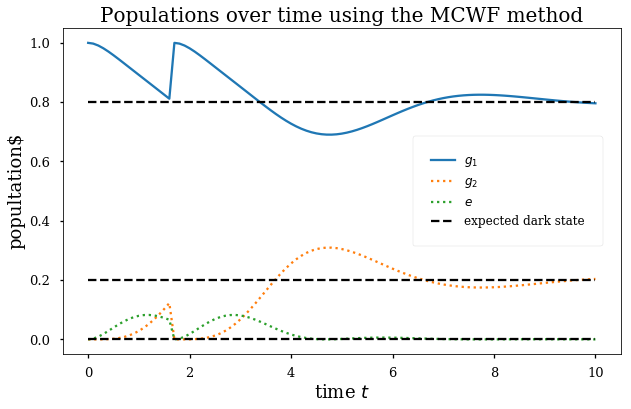

In [63]:
#Computing the relevant data
Psi_t, rho_eg1_t = singleMCWF(tvec, Psi_0, JumpOps, H_nh)

#Plotting the result
plt.plot(tvec, Psi_t[:, 0], label = '$g_1$')
plt.plot(tvec, Psi_t[:, 1], ls =':', label = '$g_2$')
plt.plot(tvec, Psi_t[:, 2], ls = ':', label = '$e$')

#Dark state from last exercise sheet
plt.plot(tvec,[0]*101, linestyle ='dashed', color = 'black', label = 'expected dark state')
plt.plot(tvec,[0.2]*101, linestyle ='dashed', color = 'black')
plt.plot(tvec,[0.8]*101, linestyle ='dashed', color = 'black')

plt.title(r'Populations over time using the MCWF method', size = 20)
plt.xlabel(r'time $t$', size = 18)
plt.ylabel(r'popultation$', size = 18)
plt.legend(frameon=True,fontsize='large', borderpad=1.5, borderaxespad=1.5,loc='best')

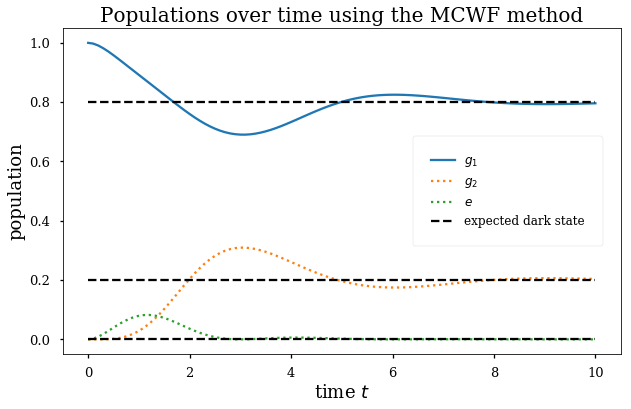

In [62]:
#Computing one single trajectory
Psi_t, rho_eg1_t = singleMCWF(tvec, Psi_0, JumpOps, H_nh)

#Plotting the result
plt.plot(tvec, Psi_t[:, 0], label = '$g_1$')
plt.plot(tvec, Psi_t[:, 1], ls =':', label = '$g_2$')
plt.plot(tvec, Psi_t[:, 2], ls = ':', label = '$e$')

#Dark state from last exercise sheet
plt.plot(tvec,[0]*101, linestyle ='dashed', color = 'black', label = 'expected dark state')
plt.plot(tvec,[0.2]*101, linestyle ='dashed', color = 'black')
plt.plot(tvec,[0.8]*101, linestyle ='dashed', color = 'black')

plt.title(r'Populations over time using the MCWF method', size = 20)
plt.xlabel(r'time $t$', size = 18)
plt.ylabel(r'population', size = 18)
plt.legend(frameon=True,fontsize='large', borderpad=1.5, borderaxespad=1.5,loc='best')

In [8]:
jumps = []
for i in range(1000):
    jumps.append(singleMCWF(tvec, Psi_0, JumpOps, H_nh, ReturnJumpCount = True)[2])

Text(0, 0.5, 'jump count')

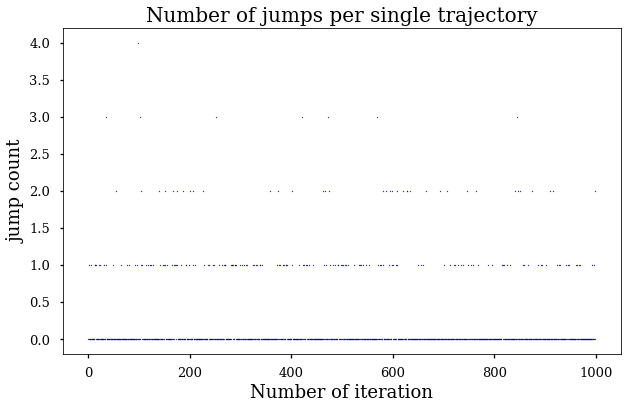

In [30]:
plt.plot(np.arange(len(jumps)), jumps, ls = '', marker = '*', markersize = 2, color = 'darkblue')
plt.title(r'Number of jumps per single trajectory', size = 20)
plt.xlabel(r'Number of iteration', size = 18)
plt.ylabel(r'jump count', size = 18)

### Discussion: 
As one can easily see the state converges against the expected dark state, even if there are no jumps. In general we can conclude that there are a lot of trajectories that don't include any jump at all, only in 197/1000 trajectories we find one or multiple jumps as displayed in the plot direclty above this cell.
Even if we only evolve without any jump, e.g. by using the non-hermitian Hamiltonian we reach the dark state. 

### Part II: "On-off" case

In [11]:
#Parameters for this setting
(gamma_p, gamma_c, gamma_g) = (1, 0.1, 0.01)
(Omega_p, Omega_c, Delta_p, Delta_c) = (1, 0.1, 0, 0)
#Initializing the settings for this exercise
(tend, dt) = (1000, 0.1)


JumpOps = buildJumpOps(gamma_p, gamma_c, gamma_g)
tvec = np.arange(0, tend, dt)
Psi_0 = states['g1']
Hmat = buildHmat(Omega_p, Omega_c, Delta_p, Delta_c)
H_nh = buildH_nh(Hmat, JumpOps)

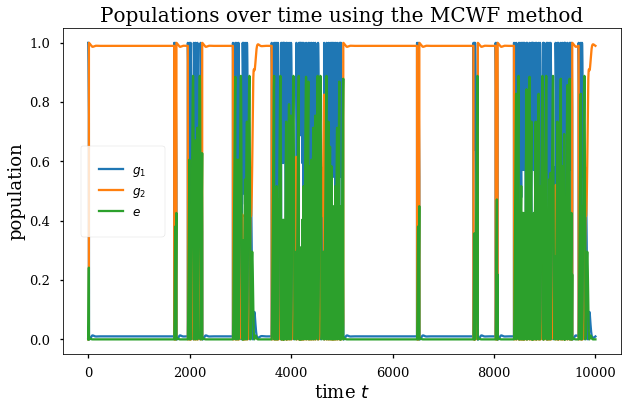

In [12]:
Psi_t, rho_eg1_t = singleMCWF(tvec, Psi_0, JumpOps, H_nh)

plt.plot(Psi_t[:, 0], label = '$g_1$')
plt.plot(Psi_t[:, 1], label = '$g_2$')
plt.plot(Psi_t[:, 2], label = '$e$')
plt.title(r'Populations over time using the MCWF method', size = 20)
plt.xlabel(r'time $t$', size = 18)
plt.ylabel(r'population', size = 18)
plt.legend(frameon=True,fontsize='large', borderpad=1.5, borderaxespad=1.5,loc='best')

### Discussion:

When implementing this setting we found out there is no exact dark state any more and we can observe a similar behavior to the "telegraph noise" from the linked paper. This is what we would have expected.

### Exercise 2 (30 points)

Implement the actual Monte Carlo wave function method: Average the observables over many jump trajectories.

To start, try the parameters of the "Standard EIT" case. For 100 jump trajectories and a time step of 0.1 you should already get reasonable results. Compare the result for the populations and the imaginary part of $\rho_{eg_1}$ (absorption) to the direct integration of the master equation from Programming Exercise 9.

Also plot ~50 single trajectories (e.g. plotting $\rho_{g_1g_1}$) into one plot to see what the averaging does.

In [13]:
#Parameters for this setting
(gamma_p, gamma_c, gamma_g) = (2, 0, 0)

(Omega_p, Omega_c, Delta_p, Delta_c) = (1, 2, 0, 0)

#Number of jump trajectories, time steps
(N, tend, dt) = (100, 10, 0.1)

In [14]:
#Initializing the settings for this exercise
JumpOps = buildJumpOps(gamma_p, gamma_c, gamma_g)
tvec = np.arange(0, tend, dt)
Psi_0 = states['g1']

Hmat = buildHmat(Omega_p, Omega_c, Delta_p, Delta_c)
H_nh = buildH_nh(Hmat, JumpOps)

#Calculating  and averaging all N trajectories
trajectories = []
rho_eg1 = []
for trajectory in range(N):
    tmp1, tmp2 = singleMCWF(tvec, Psi_0, JumpOps, H_nh)
    trajectories.append(tmp1)
    rho_eg1.append(tmp2)
trajectories = np.array(trajectories)
rho_eg1 = np.array(rho_eg1)

#Calculating the means over all trajectories
mean_traj = np.mean(trajectories, axis = 0) 
mean_rho_eg1 = np.mean(rho_eg1, axis = 0)[0]

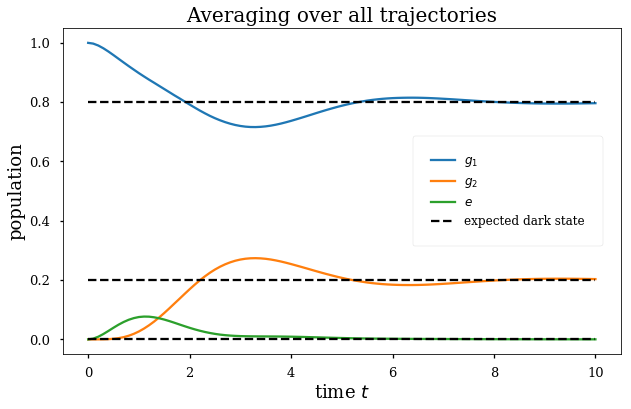

In [67]:
#Plotting the result
plt.plot(tvec, mean_traj[:, 0], label = '$g_1$')
plt.plot(tvec, mean_traj[:, 1], label = '$g_2$')
plt.plot(tvec, mean_traj[:, 2], label = '$e$')

#Dark state from last exercise sheet
plt.plot(tvec,[0]*101, linestyle ='dashed', color = 'black', label = 'expected dark state')
plt.plot(tvec,[0.2]*101, linestyle ='dashed', color = 'black')
plt.plot(tvec,[0.8]*101, linestyle ='dashed', color = 'black')

plt.title(r'Averaging over all trajectories', size = 20)
plt.xlabel(r'time $t$', size = 18)
plt.ylabel(r'population', size = 18)
plt.legend(frameon=True,fontsize='large', borderpad=1.5, borderaxespad=1.5,loc='best')

Text(0, 0.5, '$\\mathfrak{Im} \\ \\rho_{eg_1}$')

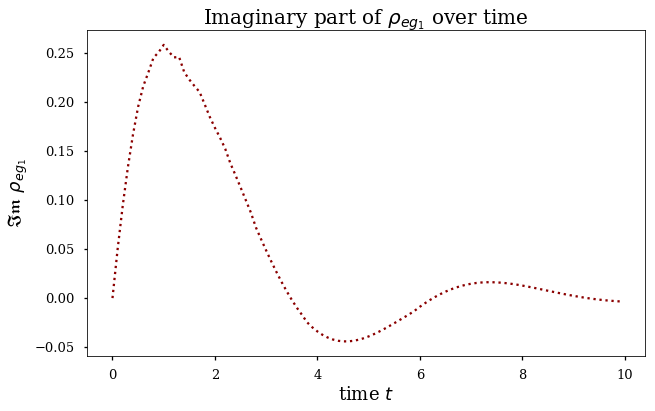

In [16]:
#Comparing the imaginary part of rho_eg1
plt.plot(tvec, mean_rho_eg1.imag, ls =':', color = 'darkred')
plt.title(r'Imaginary part of $\rho_{eg_1}$ over time', size = 20)
plt.xlabel(r'time $t$', size = 18)
plt.ylabel(r'$\mathfrak{Im} \ \rho_{eg_1}$', size = 18)

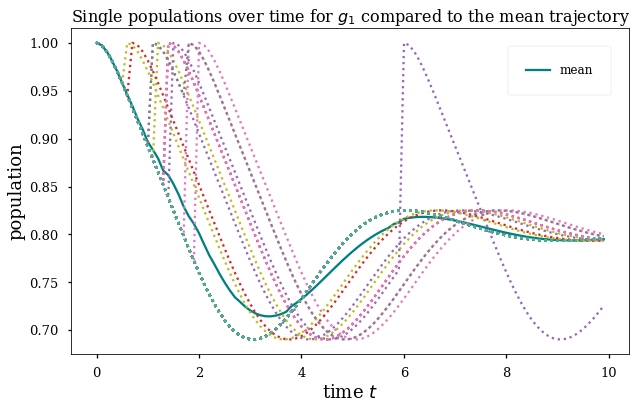

In [17]:
for i in range(50):
    plt.plot(tvec, trajectories[i, :, 0], ls =':')
plt.plot(tvec, mean_traj[:, 0], label = 'mean', zorder = -1, color = 'teal')
plt.title(r'Single populations over time for $g_1$ compared to the mean trajectory', size = 16)
plt.xlabel(r'time $t$', size = 18)
plt.ylabel(r'population', size = 18)
plt.legend(frameon=True,fontsize='large', borderpad=1.5, borderaxespad=1.5,loc='best')

### Discussion:

Our computations lead to good results compared to what we would expect. The averaging flattens the jumps out and as a final result we get a smooth curve representing the same result as determined on the last exercise sheet.

### Exercise 3 (30 points)

Study the dependence on the time step and the number of trajectories systematically. For the "Standard EIT" case, calculate at least 1000 trajectories for different time steps ranging e.g. from 0.5 to 0.001. Plot the deviation between the full master equation solution and the trajectory average as a function of the time step and also as a function of the number of trajectories. We expect to see power law decay so it makes sense to choose logarithmically spaced grids (and plot double logarithmically). To quantify the deviation, use the mean absolute deviation of the populations at t=4. One expects the error to decrease linearly with the time step and as 1/sqrt of the number of trajectories.

Optional: Different trajectories can be calculated independently form each other so this problem cries for parallelization.
Python offers a multiprocessing module for this, see e.g. https://sebastianraschka.com/Articles/2014_multiprocessing.html.
Try to speed up your simulations by using multiples cores. The even more powerful option would be to run these simulations on graphic cards, which offer the possibility of massive parallelization.


### Analytical Solution from last exercise sheet:

In [18]:
#We simply printed and copied the arrays of the solution ideas from moodle

analytical_g1 = [1.0, 0.9977395610128669, 0.9918331974971903, 0.9834093106678308, 0.9733622236773662, 
0.9623728206773597, 0.9509346663138729, 0.9393831400600131, 0.9279255189481682, 0.9166702785447934, 
0.905654316299385, 0.8948672362282888, 0.884272052327267, 0.8738219225684692, 0.8634730754346082, 
0.8531940644542969, 0.8429714959674323, 0.8328130238304198, 0.8227475492106325, 0.8128236621784796, 
0.803106572123571, 0.7936741896760777, 0.7846125362708871, 0.776011023200725, 0.7679580362137592, 
0.7605366264594967, 0.7538211730165033, 0.7478743172793013, 0.7427450499099016, 0.7384671655892874, 
0.7350587352259916, 0.7325220608395023, 0.7308442990502128, 0.7299985284109446, 0.7299451998422544, 
0.7306338841634644, 0.732005125159175, 0.7339924751896975, 0.7365244485494101, 0.7395264390398332, 
0.7429225499336775, 0.7466371635968432, 0.750596456094612, 0.7547295581731327, 0.7589695941263845, 
0.7632544810833934, 0.7675274960540576, 0.7717377013547493, 0.775840117533147, 0.7797958308301902, 
0.7835719024320464, 0.7871412096730295, 0.7904821731282149, 0.7935784228642282, 0.7964184504653656, 
0.7989951626140271, 0.8013054898220376, 0.8033499321261229, 0.8051321478660857, 0.8066585381108176, 
0.8079378381209692, 0.8089807625686134, 0.809799643684349, 0.810408101112537, 0.8108207577840979, 
0.8110529555671495, 0.8111205152407224, 0.8110395086331245, 0.8108260619289531, 0.8104961736474773, 
0.8100655626040307, 0.8095495213762286, 0.8089628022061399, 0.808319509443148, 0.8076330107519377, 
0.8069158697378943, 0.8061797795498317, 0.8054355240935177, 0.8046929420466089, 0.8039609085350554, 
0.8032473246088443, 0.8025591201164181, 0.8019022656424122, 0.8012817910091622, 0.8007018184497673, 
0.8001655947195031, 0.799675537187166, 0.7992332802459728, 0.798839729957696, 0.7984951202626429, 
0.7981990719456182, 0.7979506565947464, 0.7977484556753258, 0.7975906261045063, 0.7974749607728324, 
0.7973989495852849, 0.797359839031805, 0.7973546877504958, 0.7973804201314818, 0.797433876707515, 
0.7975118601173997]

analytical_g2 = [0.0, 5.8380866634398274e-06, 8.699516756033752e-05, 0.0004089957055572927, 0.0011970841194862505, 
0.0026992650382973537, 0.005156054293516046, 0.008777159886630448, 0.013724893071468996, 0.02010385539980772, 
0.027956185896061372, 0.037261517063151534, 0.047940821922176115, 0.05986305581149685, 0.07285401041875222, 
0.08670604694446325, 0.10118877488393307, 0.11605911402521757, 0.1310711660007418, 0.1459848424862518, 
0.1605733408585633, 0.17462930835529433, 0.18796939780031818, 0.20043760787944645, 0.21190700188960848, 
0.22228057971485718, 0.23149067253958386, 0.23949769531818135, 0.24628820684281943, 0.25187227975847265, 
0.2562806877324906, 0.2595617303676553, 0.26177817188207275, 0.26300407564177025, 0.2633218839086865, 
0.26281968192383165, 0.26158870847132676, 0.2597212021470857, 0.257308529202456, 0.2544396401926378, 
0.2511998086080235, 0.24766968537299353, 0.24392455595392384, 0.240033906837466, 0.23606108261524122, 
0.23206319084093852, 0.22809112506112578, 0.22418966556112818, 0.2203976971187647, 0.2167484615505261, 
0.21326986779398605, 0.2099848278875844, 0.20691158952897876, 0.2040641009219201, 0.20145233930988019, 
0.19908266948151937, 0.1969581587270677, 0.19507890246123133, 0.1934423264743857, 0.1920434743815745, 
0.19087530247778922, 0.18992891985802682, 0.18919388755393765, 0.18865841860359983, 0.1883096464090074, 
0.1881338392637537, 0.1881166134786628, 0.18824314439095596, 0.18849835463135187, 0.18886709622315911, 
0.18933432274050388, 0.18988523936688936, 0.1905054482220476, 0.1911810719199361, 0.19189886697423927, 
0.1926463167516296, 0.193411714610085, 0.19418422614485836, 0.19495393746890993, 0.1957118933776981, 
0.1964501125460548, 0.1971615978667428, 0.19784032765491583, 0.1984812402186082, 0.19908020549218, 
0.1996339886648665, 0.2001402059050437, 0.20059727292483684, 0.20100434964838496, 0.20136127938414508, 
0.20166852625045742, 0.2019271097953908, 0.20213854039925078, 0.20230475295224254, 0.2024280430372108, 
0.2025110046284192, 0.20255646847456754, 0.20256744726865752, 0.20254707901891014, 0.2024985788463847, 
0.2024251918446034]

analytical_e = [0.0, 0.0022546009004695087, 0.008079807335249104, 0.01618169362661168, 0.02544069220314729, 
0.03492791428434264, 0.043909279392610814, 0.0518397000533562, 0.05834958798036256, 0.06322586605539851, 
0.06638949780455333, 0.06787124670855924, 0.06778712575055656, 0.06631502162003365, 0.06367291414663928, 
0.06009988860123937, 0.055839729148634235, 0.0511278621443623, 0.04618128478862529, 0.041191495335268356, 
0.036320087017865446, 0.03169650196862775, 0.027418065928794394, 0.02355136891982832, 0.02013496189663203, 
0.017182793825645745, 0.014688154443912433, 0.012627987402516905, 0.010966743247278508, 0.009660554652239538, 
0.008660577041517285, 0.007916208792841904, 0.007377529067714062, 0.006997395947284641, 0.006732916249058773, 
0.006546433912703484, 0.0064061663694977376, 0.006286322663216391, 0.006167022248133322, 0.006033920767528562, 
0.00587764145829861, 0.005693151030162818, 0.005478987951463771, 0.0052365349894008565, 0.004969323258373847, 
0.004682328075667587, 0.004381378884816192, 0.004072633084122066, 0.0037621853480877972, 0.0034557076192831384, 
0.003158229773967038, 0.0028739624393856146, 0.0026062373428058254, 0.002357476213851161, 0.002129210224753676, 
0.0019221679044529388, 0.0017363514508941555, 0.0015711654126452702, 0.0014255256595281692, 0.001297987507607492, 
0.0011868594012411887, 0.0010903175733593437, 0.001006468761713026, 0.0009334802838627509, 0.0008695958068943476, 
0.0008132051690963233, 0.0007628712806144161, 0.0007173469759192246, 0.0006755834396945847, 0.0006367301293630523, 
0.0006001146554648631, 0.0005652392568815138, 0.0005317495718120245, 0.0004994186369153998, 0.00046812227382246103, 
0.0004378135104755055, 0.00040850584008282295, 0.00038024976162343336, 0.000353120484480696, 0.0003271980872460953, 
0.00030256284510052405, 0.0002792820168386792, 0.0002574067026716563, 0.0002369687722292106, 0.00021797605805225147, 
0.00020041661562993033, 0.00018425690778973858, 0.0001694468291897549, 0.00015592039391848782,0.00014360035321154887, 
0.00013240180392385406, 0.00012223360986248115, 0.00011300392542301836, 0.00010462094325071416,9.699618995636763e-05, 
9.004578629540579e-05, 8.369249362706076e-05, 7.786498084633246e-05, 7.25008496076881e-05, 6.754444610004712e-05, 
6.294803799662486e-05]

ana = np.array([analytical_g1, analytical_g2, analytical_e]).T

### "Standard EIT" case:

In [19]:
#Parameters for this setting
(gamma_p, gamma_c, gamma_g) = (2, 0, 0)
(Omega_p, Omega_c, Delta_p, Delta_c) = (1, 2, 0, 0)

#Calculating the Jump operators
JumpOps = buildJumpOps(gamma_p, gamma_c, gamma_g)

In [20]:
#Initializing the settings for this exercise
Psi_0 = states['g1']

Hmat = buildHmat(Omega_p, Omega_c, Delta_p, Delta_c)
H_nh = buildH_nh(Hmat, JumpOps)

analytical_solution_3 = np.array([analytical_g1[30], analytical_g2[30], analytical_e[30]])
analytical_solution_4 = np.array([analytical_g1[40], analytical_g2[40], analytical_e[40]])

dt = 0.5 is done and took 1.4438097476959229 seconds.


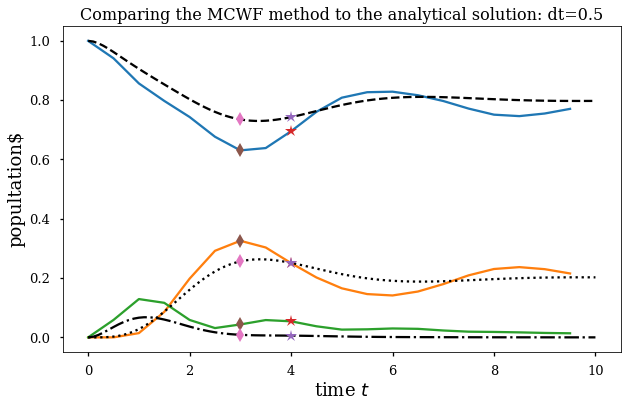

dt = 0.250659661184 is done and took 3.1455891132354736 seconds.


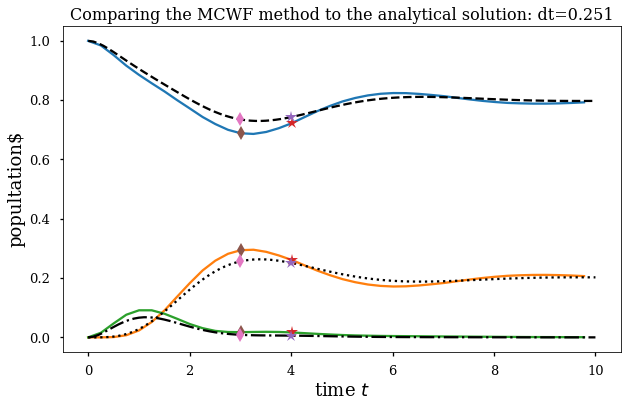

dt = 0.12566053149 is done and took 6.245629787445068 seconds.


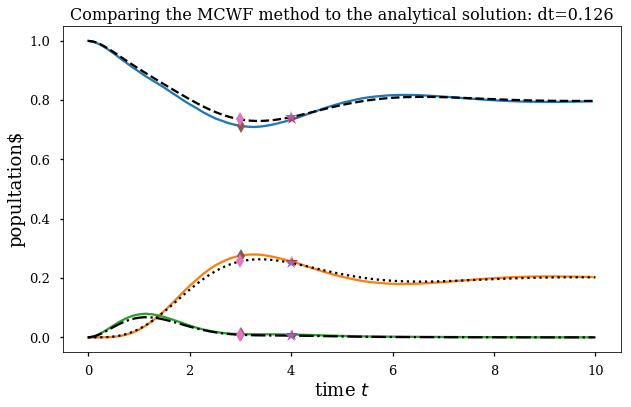

dt = 0.0629960524947 is done and took 12.132100105285645 seconds.


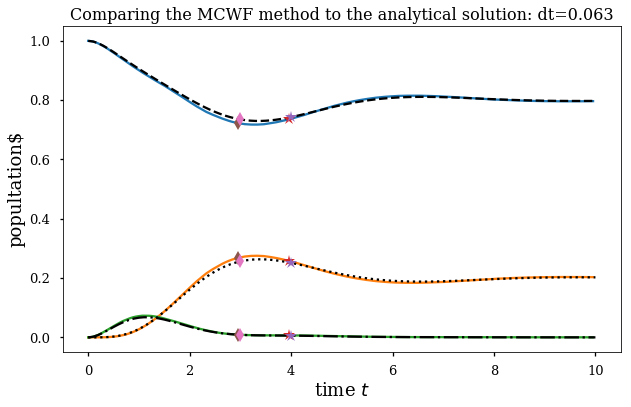

dt = 0.0315811383485 is done and took 23.986578941345215 seconds.


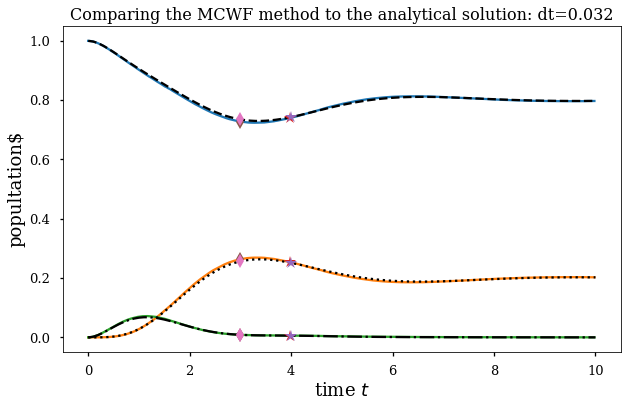

dt = 0.0158322348765 is done and took 60.34064984321594 seconds.


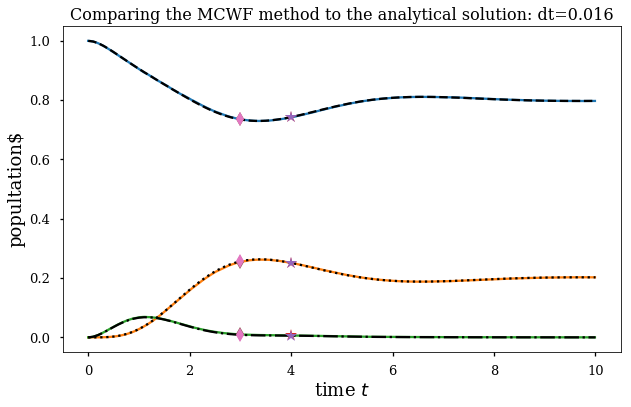

dt = 0.00793700525984 is done and took 101.72295713424683 seconds.


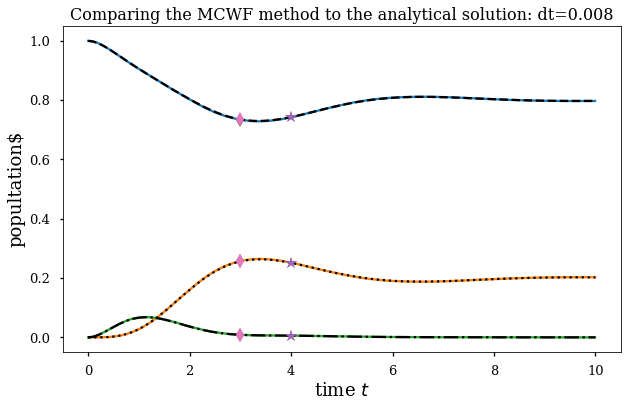

dt = 0.00397897409849 is done and took 189.47432208061218 seconds.


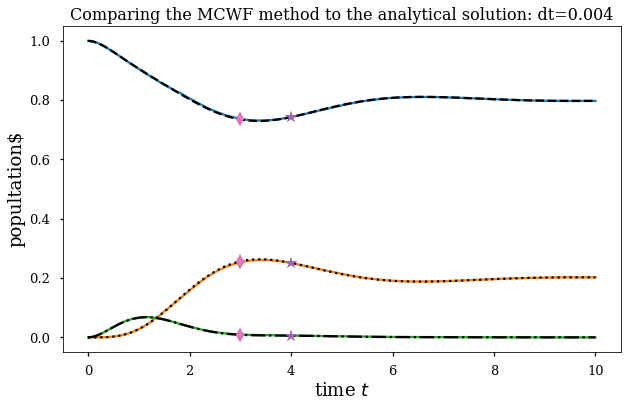

dt = 0.00199473659878 is done and took 375.2478802204132 seconds.


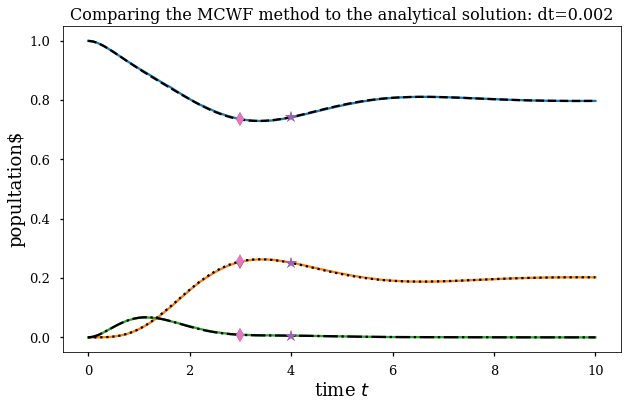

dt = 0.001 is done and took 784.2074928283691 seconds.


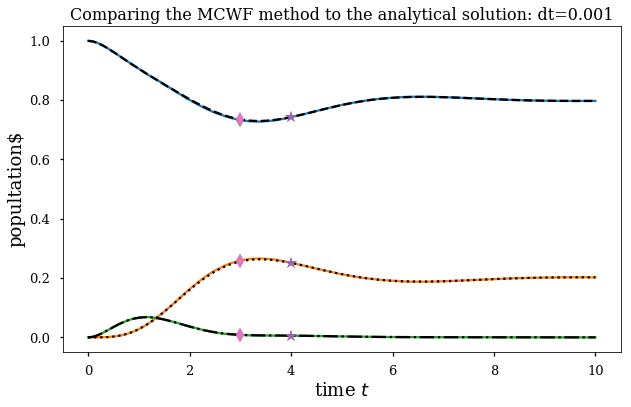

In total: 1557.9470098 seconds.


In [21]:
#Varying dt
(tend, N, dt) = (10, 1000, np.logspace(np.log10(0.5), np.log10(0.001), 10))

#Comparing the MCWF method with the analytical solution
start = time.time()
times = []
deviation_3 = []
deviation_4 = []
for dt_value in dt:
    tvec = np.arange(0, tend, dt_value)
    index_3 = int(0.3 * len(tvec))
    index_4 = int(0.4 * len(tvec))
    
    #Calculating  and averaging all N trajectories
    trajectories = []
    for trajectory in range(N):
        trajectories.append(singleMCWF(tvec, Psi_0, JumpOps, H_nh)[0])
    trajectories = np.array(trajectories)

    #Calculating the means over all trajectories
    mean_traj = np.mean(trajectories, axis = 0)
    
    deviation_3.append(mean_traj[index_3] - analytical_solution_3)
    deviation_4.append(mean_traj[index_4] - analytical_solution_4)
    
    times.append(time.time() - start)
    print('dt =', dt_value, 'is done and took', times[-1], 'seconds.')
    start = time.time()
    
    plt.plot(tvec, mean_traj)
    plt.plot(np.arange(0, 10.1, 0.1), analytical_g1, ls = '--', color = 'k')
    plt.plot(np.arange(0, 10.1, 0.1), analytical_g2, ls = ':', color = 'k')
    plt.plot(np.arange(0, 10.1, 0.1), analytical_e, ls = '-.', color = 'k')
    
    plt.plot([tvec[index_4]]*3, mean_traj[index_4], marker = '*', markersize = 12, ls = '')
    plt.plot([4]*3, analytical_solution_4, marker = '*', markersize = 12, ls = '')
    
    plt.plot([tvec[index_3]]*3, mean_traj[index_3], marker = 'd', markersize = 10, ls = '')
    plt.plot([3]*3, analytical_solution_3, marker = 'd', markersize = 10, ls = '')
    
    plt.title(r'Comparing the MCWF method to the analytical solution: dt={}'.format(np.round(dt_value,3)), size = 16)
    plt.xlabel(r'time $t$', size = 18)
    plt.ylabel(r'population', size = 18)
    plt.show()
    plt.close()
    
deviation_3 = np.array(deviation_3)
deviation_4 = np.array(deviation_4)
print('In total:', np.sum(times), 'seconds.')

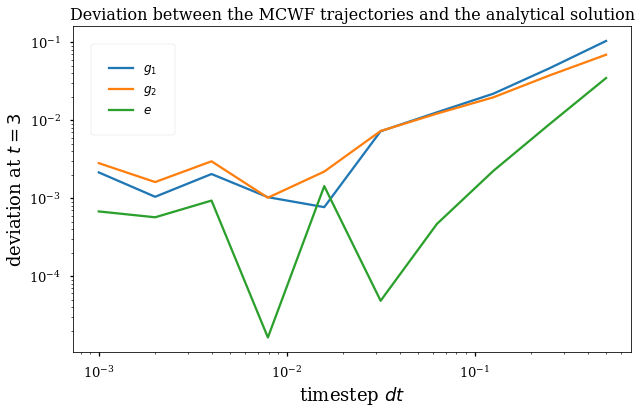

In [44]:
#Plotting the deviations for different dt
plt.loglog(dt, np.abs(deviation_3))

plt.title(r'Deviation between the MCWF trajectories and the analytical solution', size = 16)
plt.xlabel(r'timestep $dt$', size = 18)
plt.ylabel(r'deviation at $t=3$', size = 18)
plt.legend([r'$g_1$',r'$g_2$',r'$e$'],frameon=True,fontsize='large', borderpad=1.5, borderaxespad=1.5,loc='best')

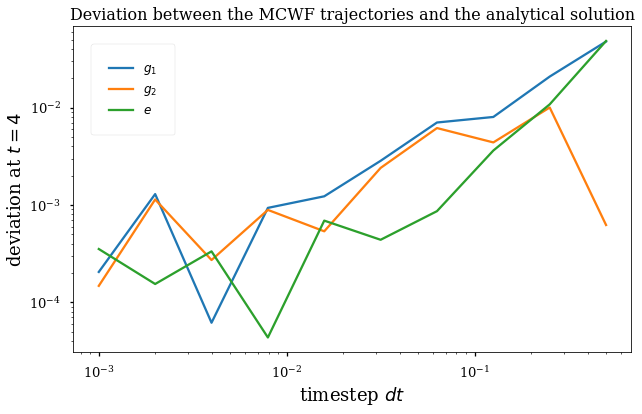

In [43]:
#Plotting the deviations for varying dt
plt.loglog(dt, np.abs(deviation_4))
plt.title(r'Deviation between the MCWF trajectories and the analytical solution', size = 16)
plt.xlabel(r'timestep $dt$', size = 18)
plt.ylabel(r'deviation at $t=4$', size = 18)
plt.legend([r'$g_1$',r'$g_2$',r'$e$'],frameon=True,fontsize='large', borderpad=1.5, borderaxespad=1.5,loc='best')

### Discussion of the dt-dependency

One can see that the results get better with smaller $dt$. Since $t=4$ is an intersection of the curves, we thought it might be better to use the deviation at $t=3$. This increases the absolute value of the deviation, but the dependence of the time step does not really look better.
Unfortunately in both cases the results are not as good as we had hoped, but one can imagine, that the deviation decreases lineraly with the time step.

N = 100 is done and took 0.7669680118560791 seconds.


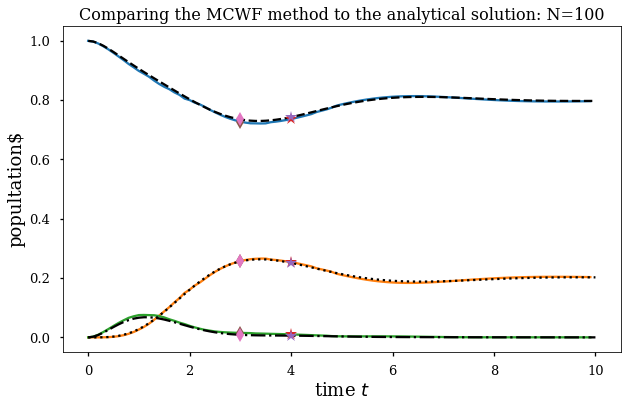

N = 193 is done and took 1.610489845275879 seconds.


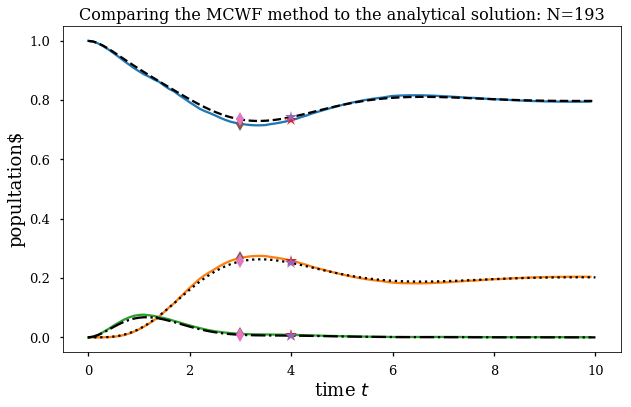

N = 372 is done and took 2.958364963531494 seconds.


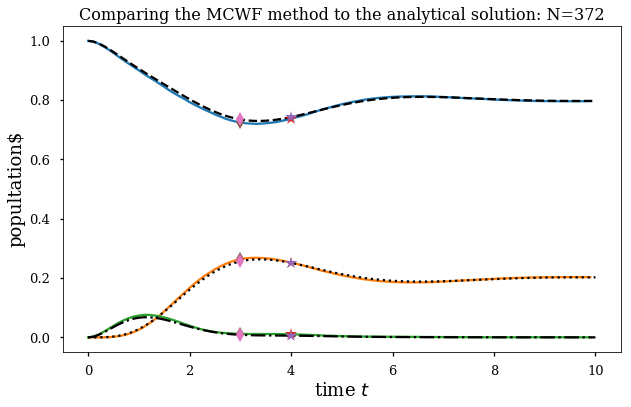

N = 719 is done and took 5.579407691955566 seconds.


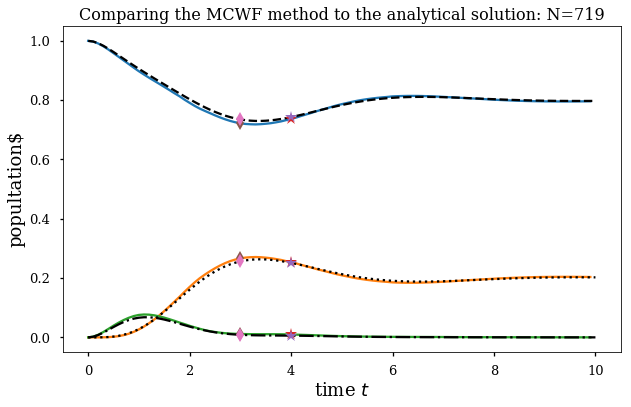

N = 1389 is done and took 10.775551080703735 seconds.


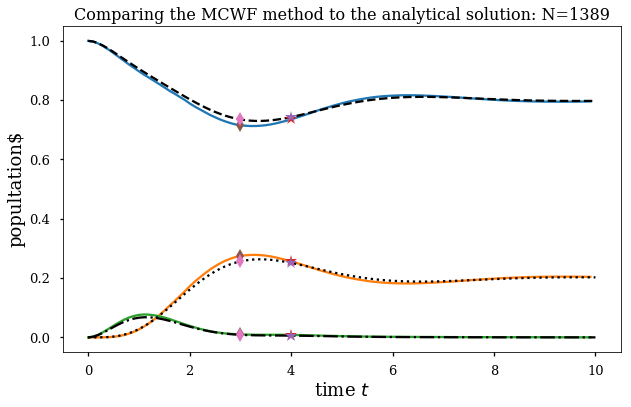

N = 2682 is done and took 20.6526780128479 seconds.


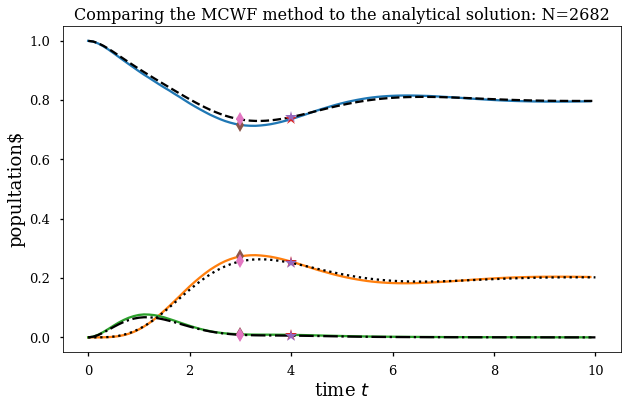

N = 5179 is done and took 39.078070878982544 seconds.


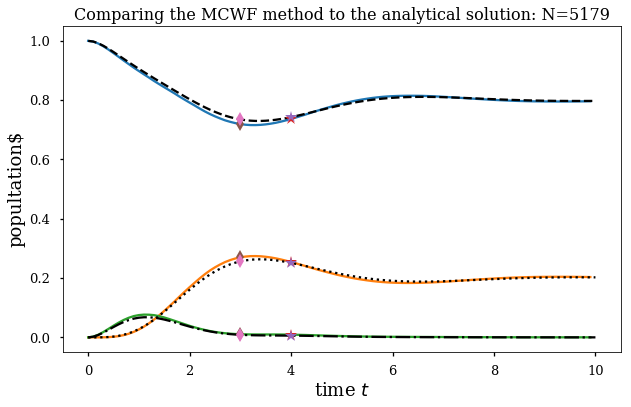

N = 10000 is done and took 74.782546043396 seconds.


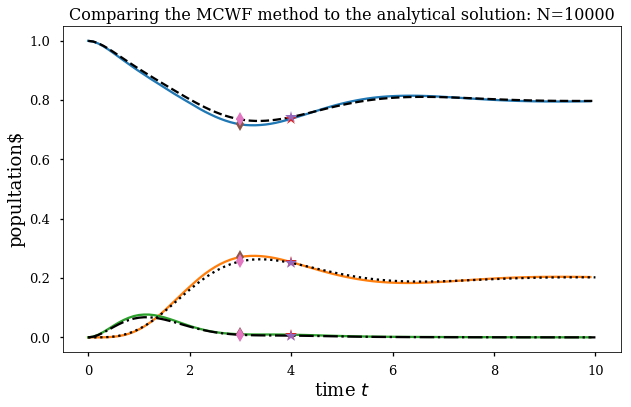

In total: 156.204076529 seconds.


In [24]:
#Varying N
(tend, N_values, dt) = (10, np.logspace(2, 4, 8, dtype = int), 0.1)
tvec = np.arange(0, tend, dt)

start = time.time()
times_N = []
deviation_N_3 = []
deviation_N_4 = []
for N_value in N_values:
    #Calculating  and averaging all N trajectories
    trajectories = []
    for trajectory in range(N_value):
        trajectories.append(singleMCWF(tvec, Psi_0, JumpOps, H_nh)[0])
    trajectories = np.array(trajectories)

    #Calculating the means over all trajectories
    mean_traj = np.mean(trajectories, axis = 0)
    
    deviation_N_3.append(mean_traj[30] - analytical_solution_3)
    deviation_N_4.append(mean_traj[40] - analytical_solution_4)
    
    times_N.append(time.time() - start)
    print('N =', N_value, 'is done and took', times_N[-1], 'seconds.')
    start = time.time()
    
    plt.plot(tvec, mean_traj)
    plt.plot(np.arange(0, 10.1, 0.1), analytical_g1, ls = '--', color = 'k')
    plt.plot(np.arange(0, 10.1, 0.1), analytical_g2, ls = ':', color = 'k')
    plt.plot(np.arange(0, 10.1, 0.1), analytical_e, ls = '-.', color = 'k')
    
    plt.plot([tvec[40]]*3, mean_traj[40], marker = '*', markersize = 12, ls = '')
    plt.plot([4]*3, analytical_solution_4, marker = '*', markersize = 12, ls = '')
    
    plt.plot([tvec[30]]*3, mean_traj[30], marker = 'd', markersize = 10, ls = '')
    plt.plot([3]*3, analytical_solution_3, marker = 'd', markersize = 10, ls = '')
    
    plt.title(r'Comparing the MCWF method to the analytical solution: N={}'.format(np.round(N_value)), size = 16)
    plt.xlabel(r'time $t$', size = 18)
    plt.ylabel(r'popultation$', size = 18)
    plt.show()
    plt.close()
    
deviation_N_3 = np.array(deviation_N_3)
deviation_N_4 = np.array(deviation_N_4)

print('In total:', np.sum(times_N), 'seconds.')

N = 1 is done and took 0.016081809997558594 seconds.


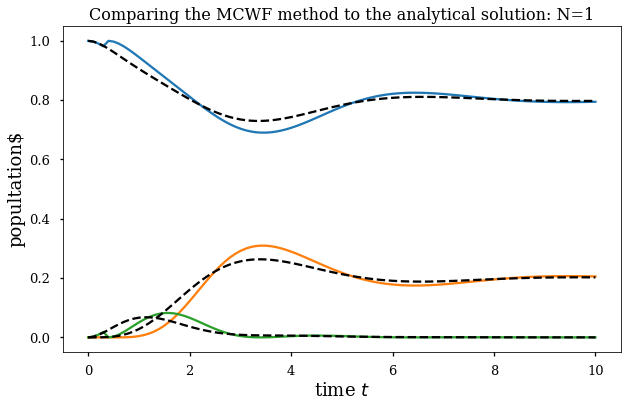

N = 3 is done and took 0.19252395629882812 seconds.


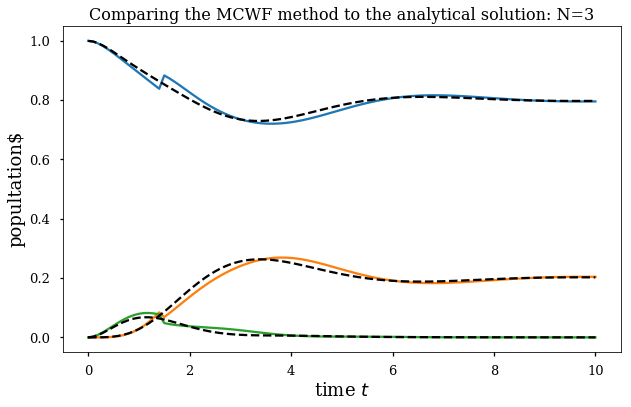

N = 13 is done and took 0.2617201805114746 seconds.


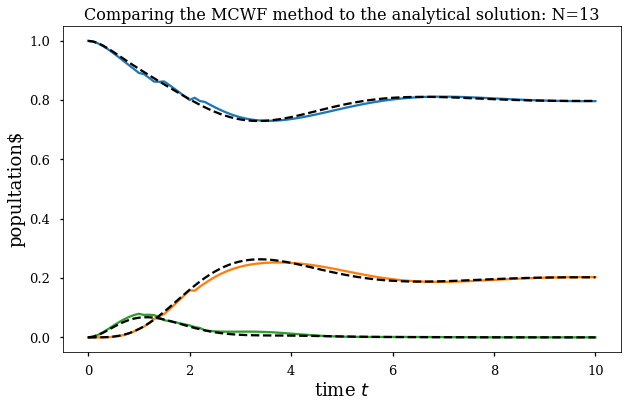

N = 51 is done and took 0.5408768653869629 seconds.


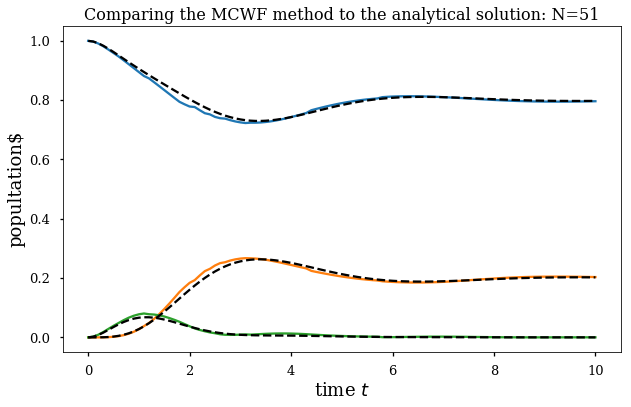

N = 193 is done and took 1.6152870655059814 seconds.


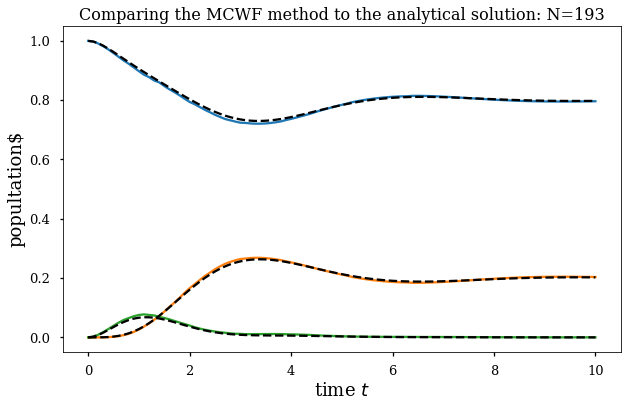

N = 719 is done and took 5.62359619140625 seconds.


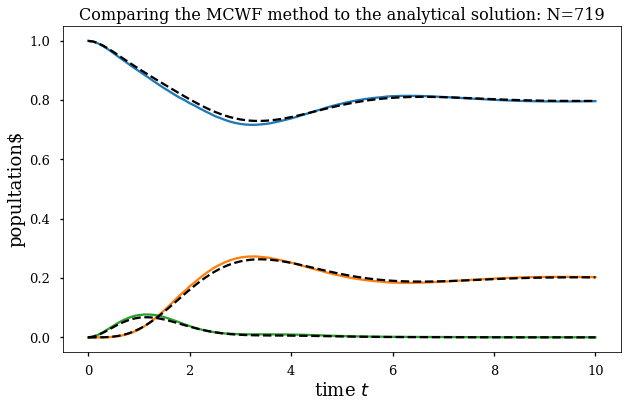

N = 2682 is done and took 20.583714962005615 seconds.


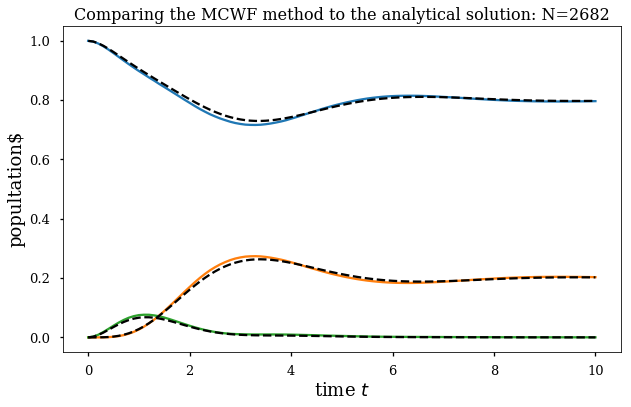

N = 10000 is done and took 75.90667510032654 seconds.


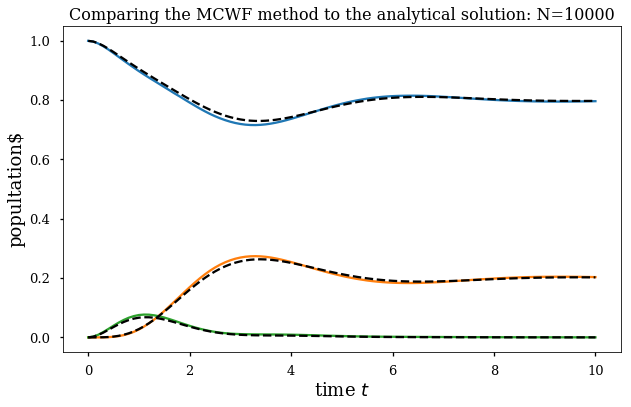

In total: 104.740476131 seconds.


In [25]:
(tend, N_values, dt) = (10.1, np.logspace(0, 4, 8, dtype = int), 0.1)
tvec = np.arange(0, tend, dt)

start = time.time()
times_N = []
deviation_N_ges = []
for N_value in N_values:
    #Calculating  and averaging all N trajectories
    trajectories = []
    for trajectory in range(N_value):
        trajectories.append(singleMCWF(tvec, Psi_0, JumpOps, H_nh)[0])
    trajectories = np.array(trajectories)

    #Calculating the means over all trajectories
    mean_traj = np.mean(trajectories, axis = 0)
    
    deviation_N_ges.append(np.sum(mean_traj - ana, axis = 0))
    
    times_N.append(time.time() - start)
    print('N =', N_value, 'is done and took', times_N[-1], 'seconds.')
    start = time.time()
    
    plt.plot(tvec, mean_traj)
    plt.plot(np.arange(0, 10.1, 0.1), ana, ls = '--', color = 'k')

    plt.title(r'Comparing the MCWF method to the analytical solution: N={}'.format(np.round(N_value)), size = 16)
    plt.xlabel(r'time $t$', size = 18)
    plt.ylabel(r'popultation$', size = 18)
    plt.show()
    
    plt.show()
    plt.close()
    
deviation_N_ges = np.array(deviation_N_ges)
print('In total:', np.sum(times_N), 'seconds.')

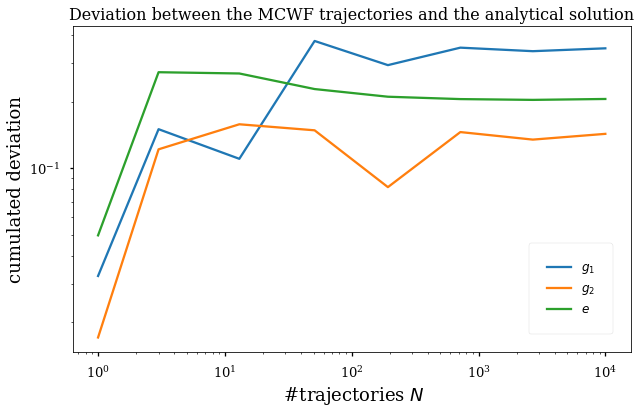

In [52]:
#Plotting the cumulated deviation for all N
plt.loglog(N_values, np.abs(deviation_N_ges))
plt.title(r'Deviation between the MCWF trajectories and the analytical solution', size = 16)
plt.xlabel(r' #trajectories $N$', size = 18)
plt.ylabel(r'cumulated deviation', size = 18)
plt.legend([r'$g_1$',r'$g_2$',r'$e$'],frameon=True,fontsize='large', borderpad=1.5, borderaxespad=1.5,loc='best')

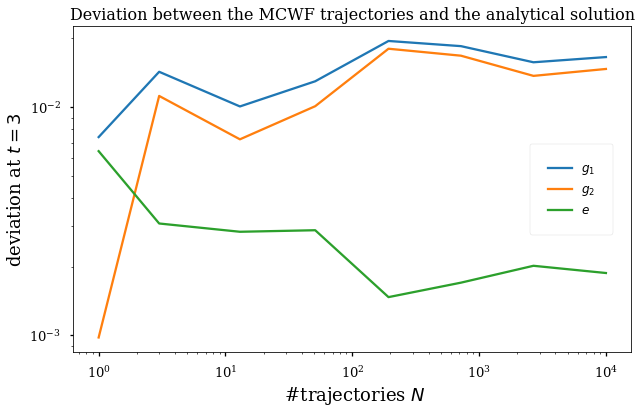

In [50]:
#Deviation at t=3
plt.loglog(N_values, np.abs(deviation_N_3))
plt.title(r'Deviation between the MCWF trajectories and the analytical solution', size = 16)
plt.xlabel(r' #trajectories $N$', size = 18)
plt.ylabel(r'deviation at $t=3$', size = 18)
plt.legend([r'$g_1$',r'$g_2$',r'$e$'],frameon=True,fontsize='large', borderpad=1.5, borderaxespad=1.5,loc='best')

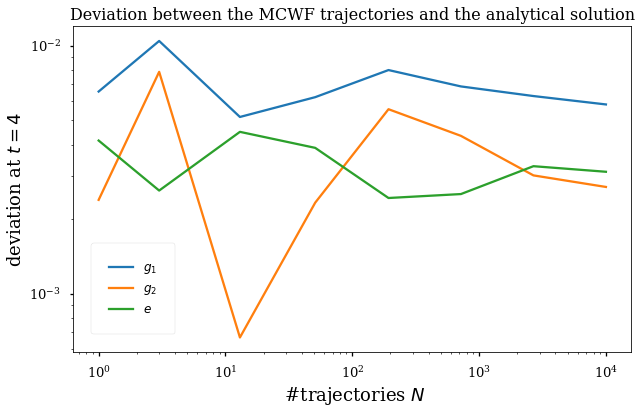

In [51]:
#Deviation at t=4
plt.loglog(N_values, np.abs(deviation_N_4))
plt.title(r'Deviation between the MCWF trajectories and the analytical solution', size = 16)
plt.xlabel(r' #trajectories $N$', size = 18)
plt.ylabel(r'deviation at $t=4$', size = 18)
plt.legend([r'$g_1$',r'$g_2$',r'$e$'],frameon=True,fontsize='large', borderpad=1.5, borderaxespad=1.5,loc='best')

### Discussion of the N-dependency

One can see that the results get better with greater $N$. Again we also calculated the deviation for $t=3$, for the same reason as above. Since the arrays have the same dimension we also calculated the summed up deviation. 
Unfortunately in both cases the results are not as good as we had hoped, but one can imagine, that the deviation decreases lineraly with $1/\sqrt N$.